In [1]:
import numpy as np
import scipy.io as scio
# import scipy.sparse as sp
# import hdf5storage # get code on https://pypi.python.org/pypi/hdf5storage/0.1.3
# import networkx as nx

import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 写入mat
def WriteMatlab(data_np, VarName, FileName):
    matcontent = {}
    matcontent[VarName] = data_np
    hdf5storage.write(matcontent, filename=FileName, matlab_compatible=True)

In [4]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/WS_2000_10_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'],dtype=int)
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_10_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'],dtype=int)
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size doesn\'t match!"

assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"

if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [5]:
# 参数设置

# 0. 公共参数
Monte_Carlo_loop = 10     # 蒙特卡洛模拟次数
time_steps = 50           # 总时间步数
N = network_scale_1[0]     # 网络节点数
w = 0.6                    # S-I断边概率
beta_list = [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
             0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
             0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
             0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80, \
             0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.00]

# 1. SIS参数
# bata = 0.2    # 感染概率
mu = 0.4      # 恢复概率

# 2. UAU参数
lamda = 0.3    # 传播率
delta = 0.6    # 遗忘率

# 4. 其他参数
aplha = 0.4      # 信息上传率
iter_ = 0

infective_count_average_total = np.zeros([time_steps])
awareness_count_average_total = np.zeros([time_steps])

In [6]:
for bata in beta_list:
    
    time_start_w = time.time()
    
    random.seed(512)
    np.random.seed(512)

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)                # 记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)             # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])


    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)       # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])



    time_start = time.time()

    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        network_physical_t = np.zeros([time_steps, N, N],dtype=int)    # 每一步接触网络的快照
        network_physical_t[0,:,:] = network_physical[:, :]             # 每一步初始时刻接触网络为原始网络


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                    # -----UAU传播过程-----
                    a_1 = 1 - (1 - lamda) ** Num_neighbor_listener    # 最终计算的传播率
                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a_1:
                        Nodes_UAU[loop, t+1, i] = 1
                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘
                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉 


            # ----------更改连边----------
            for i in range(N):
                if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
                    
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
                    susceptible_nodes = np.where((Nodes_SIS[loop, t, :] == 0))[0]                 # 易感节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居
                    # neighbor_susceptible = np.intersect1d(susceptible_nodes, neighbor_total)        # 取交集-易感邻居
                    neighbor_susceptible = np.setdiff1d(neighbor_total, neighbor_infective)       # 邻居里去除感染邻居-易感邻居

                    destinations = list(np.setdiff1d(susceptible_nodes, neighbor_susceptible))    #  可以选择连接的非邻居易感节点

                    for infectNeighbor in neighbor_infective:
                        # 如果断边成功，则在当前时刻更改连接
                        if np.random.rand(1) <= w:
                            network_physical_t[t,i,infectNeighbor] = 0
                            network_physical_t[t,infectNeighbor,i] = 0

                            destination = random.choice(destinations)
                            destinations.remove(destination)

                            network_physical_t[t,i,destination] = 1
                            network_physical_t[t,destination,i] = 1

            # ----------SIS演化----------
            for i in range(N):

            # # 0代表易感(S)，如果节点是US，则不做改变，正常感染
            # if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 0)):

                if Nodes_SIS[loop, t, i] == 0:

                    neighbor_total = np.where((network_physical_t[t, i, :] == 1))[0]          # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]               # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)      # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)                          # 统计数量

                    # -----SIS感染过程1-----
                    # SIS感染率
                    v_1 = 1 - (1 - bata) ** Num_neighbor_infective
                    p = np.random.rand(1)
                    if p <= v_1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0


                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")

            # 将当前时间的接触网络复制到下一时刻
            network_physical_t[t+1,:,:] = network_physical_t[t,:,:]

        # 保存本次蒙特卡洛循环产生的接触网络数据
        # addr_mat = '../results/loop/'+'loop_'+str(loop)+'.mat'
        # # addr_csv = '../results/loop/'+'loop_'+str(loop)+'.csv'
        # name = 'loop_'+str(loop)
        # scio.savemat(addr, {name: network_physical_t})
        # # np.savetxt(addr_csv, network_physical_t, fmt = '%d', delimiter = ',')

        print("    loop {} - time has passed: {} ".format(loop, time.time()-time_start))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
        awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
    awareness_count_average = np.mean(awareness_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
    assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"

    infective_count_average_total[iter_] = (infective_count_average/N)[time_steps-1]
    awareness_count_average_total[iter_] = (awareness_count_average/N)[time_steps-1]
    iter_ += 1

    print("beta = {} - time has passed: {} ".format(bata, time.time()-time_start))

    loop 0 - time has passed: 65.9200587272644 
    loop 1 - time has passed: 137.0511999130249 
    loop 2 - time has passed: 208.63108897209167 
    loop 3 - time has passed: 273.5821340084076 
    loop 4 - time has passed: 340.72062826156616 
    loop 5 - time has passed: 404.97362446784973 
    loop 6 - time has passed: 468.1524934768677 
    loop 7 - time has passed: 530.6018426418304 
    loop 8 - time has passed: 596.2933557033539 
    loop 9 - time has passed: 662.8664767742157 
beta = 0.02 - time has passed: 662.869478225708 
    loop 0 - time has passed: 66.44219923019409 
    loop 1 - time has passed: 131.24114561080933 
    loop 2 - time has passed: 196.75911140441895 
    loop 3 - time has passed: 261.96501755714417 
    loop 4 - time has passed: 326.93607449531555 
    loop 5 - time has passed: 396.17284059524536 
    loop 6 - time has passed: 467.10785007476807 
    loop 7 - time has passed: 531.0335555076599 
    loop 8 - time has passed: 594.6357069015503 
    loop 9 -

    loop 1 - time has passed: 75.66914701461792 
    loop 2 - time has passed: 113.84344696998596 
    loop 3 - time has passed: 151.11814951896667 
    loop 4 - time has passed: 188.9254949092865 
    loop 5 - time has passed: 226.4543652534485 
    loop 6 - time has passed: 264.8468105792999 
    loop 7 - time has passed: 303.05112981796265 
    loop 8 - time has passed: 340.6713619232178 
    loop 9 - time has passed: 378.3293197154999 
beta = 0.32 - time has passed: 378.33632469177246 
    loop 0 - time has passed: 37.72800278663635 
    loop 1 - time has passed: 79.47266721725464 
    loop 2 - time has passed: 120.26170182228088 
    loop 3 - time has passed: 161.20792317390442 
    loop 4 - time has passed: 202.39521837234497 
    loop 5 - time has passed: 244.04782104492188 
    loop 6 - time has passed: 284.81884121894836 
    loop 7 - time has passed: 354.27715277671814 
    loop 8 - time has passed: 395.9847922325134 
    loop 9 - time has passed: 437.4062428474426 
beta = 0.

    loop 2 - time has passed: 104.74033188819885 
    loop 3 - time has passed: 138.65080571174622 
    loop 4 - time has passed: 172.91951704025269 
    loop 5 - time has passed: 207.46901202201843 
    loop 6 - time has passed: 241.66667532920837 
    loop 7 - time has passed: 276.13451743125916 
    loop 8 - time has passed: 310.42424297332764 
    loop 9 - time has passed: 345.0311768054962 
beta = 0.62 - time has passed: 345.03518080711365 
    loop 0 - time has passed: 34.59692931175232 
    loop 1 - time has passed: 68.8039608001709 
    loop 2 - time has passed: 103.03364562988281 
    loop 3 - time has passed: 137.36740016937256 
    loop 4 - time has passed: 171.69715237617493 
    loop 5 - time has passed: 206.15698742866516 
    loop 6 - time has passed: 241.00342655181885 
    loop 7 - time has passed: 275.556325674057 
    loop 8 - time has passed: 310.085209608078 
    loop 9 - time has passed: 344.72116351127625 
beta = 0.64 - time has passed: 344.7251675128937 
    loo

    loop 3 - time has passed: 118.99125504493713 
    loop 4 - time has passed: 147.1409089565277 
    loop 5 - time has passed: 176.42531728744507 
    loop 6 - time has passed: 205.57863759994507 
    loop 7 - time has passed: 233.77932858467102 
    loop 8 - time has passed: 261.7278480529785 
    loop 9 - time has passed: 290.4532952308655 
beta = 0.92 - time has passed: 290.45629954338074 
    loop 0 - time has passed: 28.407827615737915 
    loop 1 - time has passed: 56.58950448036194 
    loop 2 - time has passed: 85.87190842628479 
    loop 3 - time has passed: 113.56526184082031 
    loop 4 - time has passed: 141.28263092041016 
    loop 5 - time has passed: 169.10109543800354 
    loop 6 - time has passed: 198.71371841430664 
    loop 7 - time has passed: 226.56017470359802 
    loop 8 - time has passed: 254.89295053482056 
    loop 9 - time has passed: 282.46422362327576 
beta = 0.94 - time has passed: 282.46722531318665 
    loop 0 - time has passed: 24.875489473342896 
   

In [7]:
# plt.plot(infective_count_average/N, color='blue', label='SIS')
# plt.plot(awareness_count_average/N, color='green', label='UAU')

In [8]:
addr = '../../results/'
name1 = 'WS_WS_beta_infective_w_06'
name2 = 'WS_WS_beta_awareness_w_06'
scio.savemat(addr+name1+'.mat', {name1: infective_count_average_total})
scio.savemat(addr+name2+'.mat', {name2: awareness_count_average_total})

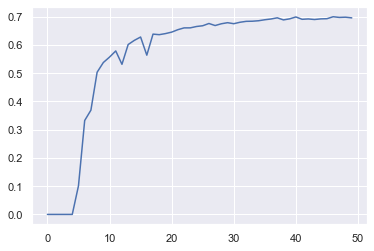

In [9]:
plt.plot(infective_count_average_total)